# **Data Augmentation for Support Vector Machines**

  In this small notebook, we want to test an SVM algorithm with Data augmentation, as described in the paper Data Augmentation for Support Vector Machines, written by N.polson and S. L. Scott in 2011. 
A source is  https://projecteuclid.org/journals/bayesian-analysis/volume-6/issue-1/Data-augmentation-for-support-vector-machines/10.1214/11-BA601.full. 
At first we will display a point estimation by EM and related algorithm, then we will use MCMC techniques for SVM.

Here we import some packages for the project and some packages for datasets.

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from scipy.integrate import quad    
from scipy.special import gamma
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn import datasets
from sklearn.preprocessing import StandardScaler


Now we can load some datasets for SVM : an example is breast cancer dataset (Source : https://scikit-learn.org/stable/datasets/toy_dataset.html) where we want to predict the class of the cancer : malignant (1) or benign (0).
We normalisee the dataset with the z-core

In [22]:
#dataset with two classes for breast cancer
dataset_cancer = datasets.load_breast_cancer()
features_names = dataset_cancer.feature_names
non_normalized_dataframe_cancer = pd.DataFrame(dataset_cancer.data, 
                                columns = dataset_cancer.feature_names)
dataframe_cancer = pd.DataFrame(StandardScaler().fit_transform(non_normalized_dataframe_cancer), 
                      columns =  dataset_cancer.feature_names)
dataframe_cancer['target'] = pd.Series(dataset_cancer.target)


We convert the dataset into a numpy dataset.

In [23]:
#We tranform the dataset into a numpy array.
X0 = dataframe_cancer[features_names].to_numpy()

#We add column for constant term.
n_lines0, n_columns0 = np.shape(X0)
X = np.append(X0, [[1] for i in range(n_lines0)], axis = 1) 

#y takes from -1,1 for the algorithm.
n_lines, n_colums = np.shape(X)
y = 2*dataframe_cancer['target'].to_numpy() - np.ones(n_lines) 


Now, separate the dataset into a train set (75%) and a test set (25%)

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, 
                                                    random_state=42)


We write some useful functions for our algorithm.
All the differents formulas are noted in the paper.


In [25]:
def parameters(x, y):
    n, k = np.shape(x)
    sigma = np.array([np.std(x[:][j]) for j in range(k)])
    big_sigma = np.diag(np.square(sigma))
    bold_X = np.array([y[i]*x[i] for i in range(n)])
    return (sigma,  big_sigma, bold_X)

def E_Step(nu, sigma, x, y, beta):
    n, k = np.shape(x)
    lambda_g = np.array([np.abs(1/(1-(y[i]*np.dot(x[i].T, beta)))) 
              for i in range(n)])
    big_lambda_g = np.diag(lambda_g)
    omega_g = np.diag([nu * sigma[j] * np.abs(1/beta[j]) for j in range(k)])
    return (lambda_g, big_lambda_g, omega_g)

def CVM_Step(omega_g, lambda_g, big_lambda_g, big_sigma, bold_X, x, y, nu):
    n, k = np.shape(x)
    beta = np.dot(np.linalg.inv((nu**(-2) * np.dot(np.linalg.inv(big_sigma), 
          omega_g)) + np.dot(bold_X.T, np.dot(big_lambda_g, bold_X))),
          np.dot(bold_X.T, np.ones(n)+ lambda_g))
    return beta

def CME_Step(sigma, alpha, beta, x, y, b_nu, a_nu, nu):
    n, k = np.shape(x)
    numerator = b_nu + np.sum([(np.abs(beta[j]/sigma[j]))**alpha for j in range(k)])
    denominator = k/alpha + a_nu - 1
    return (numerator/denominator)**(-1/alpha)


Now we build ours algorithms of EM and ECME.

In [26]:
def EM_SVM_algorithm(x, y, nu, beta, epsilon, n_max_step):
    n, k = np.shape(x)
    previous_beta = np.array([np.inf for i in range (k)])
    (sigma,  big_sigma, X) = parameters(x, y)
    step = 0
    while (np.linalg.norm(beta-previous_beta) > epsilon) and (step < n_max_step):
        previous_beta = beta
        lambda_g, big_lambda_g, omega_g = E_Step(nu, sigma, x, y, beta)
        beta = CVM_Step(omega_g, lambda_g, big_lambda_g, big_sigma, X, x, y, nu)
        step += 1
    return (beta)

def ECME_SVM_algorithm(x, y, nu, beta, epsilon, alpha, b_nu, a_nu, n_max_step) :
    n, k = np.shape(x)
    previous_beta = np.array([np.inf for i in range (k)])
    previous_nu = np.array([np.inf for i in range (k)])
    (sigma,  big_sigma, X) = parameters(x, y)
    step = 0
    while (max(np.linalg.norm(beta-previous_beta),np.linalg.norm(nu-previous_nu)) 
         > epsilon) and (step < n_max_step):
        previous_beta = beta
        previous_nu = nu
        lambda_g, big_lambda_g, omega_g = E_Step(nu, sigma, x, y, beta)
        beta = CVM_Step(omega_g, lambda_g, big_lambda_g, big_sigma, X, x, y, nu)
        nu = CME_Step(sigma, alpha, beta, x, y, b_nu, a_nu, nu)
        step += 1
    return (beta)


We build a small function to get some machine learning results.


In [27]:
def scores(predict_data, test_data):
    n = len(test_data)
    n_real_positive = (test_data > 0).sum() # True positive & false negative
    n_predicted_positive = (predict_data > 0).sum() #True positive & false positive
    n_true_positive = 0 #True positive 
    for i in range(n):
        if (predict_data[i] == 1) and  (test_data[i] == 1) :
            n_true_positive +=1
    precision = n_true_positive/n_predicted_positive * 100
    recall = n_true_positive/n_real_positive * 100
    f1_score = (2*recall*precision)/(recall + precision)
    return (precision, recall, f1_score)


Now we can test our algothms and compared them to a standardised python method. In this first test $\nu = 1$ for EM.

In [28]:
#Test on cancer data
#Some external variables
n_max_step = 100
epsilon = 1

#Some other variables initialized
n_row, n_column = np.shape(X_train)
beta = 1*np.ones(n_column)
nu = 0.01
a_nu = 1
b_nu = 1
alpha = 1

#Estimations of betas with the algorithms
beta_EM = EM_SVM_algorithm(X_train, y_train, nu, beta, epsilon, n_max_step)
beta_ECME = ECME_SVM_algorithm(X_train, y_train, nu, beta, 
                               epsilon, alpha, b_nu, a_nu, n_max_step)

#Test on test data 

y_pred_EM = np.sign(np.dot(beta_EM,X_test.T))
y_pred_ECME = np.sign(np.dot(beta_ECME,X_test.T))
precion_EM, recall_EM, f1_score_EM = scores(y_pred_EM, y_test)
precion_ECME, recall_ECME, f1_score_ECME = scores(y_pred_ECME, y_test)

print('precion_EM :', precion_EM, ', recall_EM :',
      recall_EM, ', f1_score_EM :',f1_score_EM)
print('precion_ECME :', precion_ECME, ', recall_ECME :',
      recall_ECME,', f1_score_ECME :', f1_score_ECME)

#Classic SVM 
svm_model =  SVC(kernel = 'linear')
svm_model.fit(X_train, y_train)
y_pred_sklearn = svm_model.predict(X_test)
precion_sklearn, recall_sklearn, f1_score_sklearn = scores(y_pred_sklearn, 
                                                           y_test)
print('precision_sklearn :', precion_sklearn, ', recall_sklearn :',
      recall_sklearn, ', f1_score_sklearn :', f1_score_sklearn)


precion_EM : 98.80952380952381 , recall_EM : 93.25842696629213 , f1_score_EM : 95.95375722543352
precion_ECME : 98.83720930232558 , recall_ECME : 95.50561797752809 , f1_score_ECME : 97.14285714285714
precision_sklearn : 98.86363636363636 , recall_sklearn : 97.75280898876404 , f1_score_sklearn : 98.30508474576271


We test that for differents value of nu for EM and plot the results.

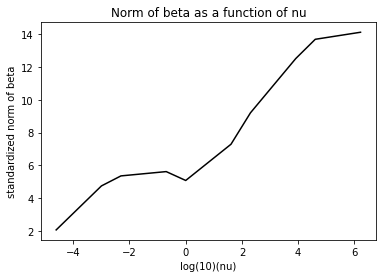

In [29]:
nus = np.array([0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500])
n, k = np.shape(X_train)
sigma = np.array([np.std(X_train[:][j]) for j in range(k)])
normalised_norm = []
for nu in nus:
    result_beta = EM_SVM_algorithm(X_train, y_train, nu, beta, epsilon, n_max_step)
    normalised_beta = [result_beta[j] * sigma[j] for j in range(k)]
    normalised_norm.append(np.linalg.norm(normalised_beta))

plt.plot(np.log(nus), normalised_norm, color = 'black')
plt.xlabel('log(10)(nu)')
plt.ylabel('standardized norm of beta')
plt.title('Norm of beta as a function of nu')
plt.show()


Now we plot the coeffictions of our algorithms and sklearn coefficients

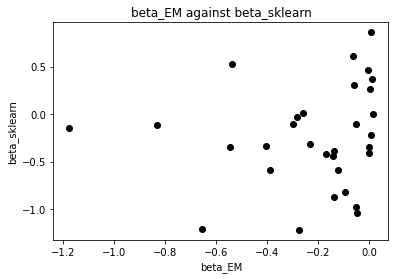

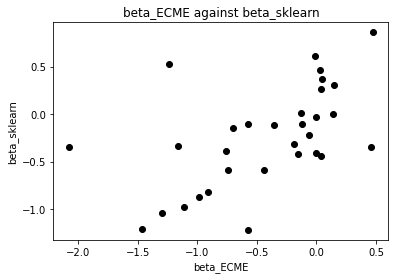

In [30]:
beta_sklearn = svm_model.coef_[0]

#EM algorithm
plt.scatter(beta_EM, beta_sklearn, color = 'black')
plt.xlabel('beta_EM')
plt.ylabel('beta_sklearn')
plt.title('beta_EM against beta_sklearn')
plt.show()

#ECME algorithm
plt.scatter(beta_ECME, beta_sklearn, color = 'black')
plt.xlabel('beta_ECME')
plt.ylabel('beta_sklearn')
plt.title('beta_ECME against beta_sklearn')
plt.show()
